In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.pyplot import colorbar
from matplotlib.transforms import Bbox
from scipy.spatial.distance import cdist
import elfi
from os import makedirs
%load_ext autoreload
%autoreload 2

In [2]:
from model.setup_LV import *
selfi_LV_modelA.load(fnameA)
F_0=selfi_LV_modelA.F_0

[19:13:17|STATUS    ]|Reading data compression information in data file '/home/leclercq/codes/pyselfi/pyselfi_examples/lotkavolterra/sims/selfi_LV_modelA.h5'...
[19:13:17|STATUS    ]|Reading data compression information in data file '/home/leclercq/codes/pyselfi/pyselfi_examples/lotkavolterra/sims/selfi_LV_modelA.h5' done.


In [3]:
# Set the seed for reproducibility
np.random.seed(seed)

In [4]:
nBins = 30
nContourLevels = 3
# 2d contour levels: (68%, 95%, 99%)
confLevels = [.3173, .0455, .0027]
confLevels_grid = [-6.18/2,-4.61/2,-2.30/2,0]

smoothingKernel = 1
filledPlots = True
truthColors = np.expand_dims(np.array('black'), axis=0)
truthLineStyles = np.expand_dims(np.array('--'), axis=0)
plotDensity = False
figureWidth = 8

colorsDict = {
              # Match pygtc up to v0.2.4
              'blues_old' : ('#4c72b0','#7fa5e3','#b2d8ff'),
              'greens_old' : ('#55a868','#88db9b','#bbffce'),
              'yellows_old' : ('#f5964f','#ffc982','#fffcb5'),
              'reds_old' : ('#c44e52','#f78185','#ffb4b8'),
              'purples_old' : ('#8172b2','#b4a5e5','#37d8ff'),
              # New color scheme, dark colors match matplotlib v2
              'blues' : ('#1f77b4','#52aae7','#85ddff'),
              'oranges' : ('#ff7f0e','#ffb241','#ffe574'),
              'greens' : ('#2ca02c','#5fd35f','#92ff92'),
              'reds' : ('#d62728','#ff5a5b','#ff8d8e'),
              'purples' : ('#9467bd','#c79af0','#facdff'),
              'browns' : ('#8c564b','#bf897e','#f2bcb1'),
              'pinks' : ('#e377c2','#ffaaf5','#ffddff'),
              'grays' : ('#7f7f7f','#b2b2b2','#e5e5e5'),
              'yellows' : ('#bcbd22','#eff055','#ffff88'),
              'cyans' : ('#17becf','#4af1ff','#7dffff'),
          }
defaultColorsOrder = ['blues', 'oranges','greens', 'reds', 'purples',
                    'browns', 'pinks', 'grays', 'yellows', 'cyans']
colorsOrder = defaultColorsOrder
colors = [colorsDict[cs] for cs in colorsOrder]

In [5]:
def get_kde_values(samples1,samples2,min1,max1,n1,min2,max2,n2):
    from scipy.stats import gaussian_kde
    values = np.vstack([samples1, samples2])
    kernel = gaussian_kde(values)

    A, B = np.mgrid[min1:max1:n1*1j, min2:max2:n2*1j]
    positions = np.vstack([A.ravel(), B.ravel()])
    Z = np.reshape(kernel(positions).T, A.shape).T
    Z = np.log(Z)
    Z -= np.max(Z)
    return Z

def get_marginal(samples, nBins=nBins):
    from scipy.ndimage import gaussian_filter1d
    # create 1d histogram
    hist1d, edges = np.histogram(samples, weights=np.ones_like(samples),
        density=True, bins=nBins)

    # Bin center between histogram edges
    centers = (edges[1:]+edges[:-1])/2

    # Filter data
    pdf = np.array((centers, hist1d))
    pdf = gaussian_filter1d(pdf, sigma=smoothingKernel)

    # Clip the pdf to zero out of the bins
    centers, hist = pdf[0], pdf[1]
    centers = np.insert(centers, 0, centers[0]-(centers[1]-centers[0]))
    hist = np.insert(hist, 0, 0.)
    centers = np.insert(centers, len(centers), centers[len(centers)-1]-(centers[len(centers)-2]-centers[len(centers)-1]))
    hist = np.insert(hist, len(hist), 0.)

    # Normalize all the pdfs to the same height
    hist /= hist.max()

    pdf = np.array((centers, hist))
    
    return pdf

# Set up the simulator and compressor

In [6]:
def ssimulator(alpha, beta, gamma, delta, simulator_args, batch_size=1, random_state=None):
    omega = np.array([alpha, beta, gamma, delta])
    theta = selfi_LV_modelA.LVsimulator.compute_theta(omega, t, t_s, tres)
    return bbA.evaluate(theta, seed=None, i=0, N=batch_size)

simulator_args=None

In [7]:
def compressor(d, batch_size=1, random_state=None):
    return selfi_LV_modelA.score_compression(d)

# Load and compress observed data

In [8]:
compressed_data = compressor(phi_obs)
compressed_data

array([0.70503559, 0.22871117, 0.14711977, 0.0414676 ])

In [9]:
def simulator(alpha, beta, gamma, delta, simulator_args, batch_size=1, random_state=None):
    data = ssimulator(alpha, beta, gamma, delta, simulator_args, 1, random_state)
    return data

simulator_vec = elfi.tools.vectorize(simulator, [4])

compressor_vec = elfi.tools.vectorize(compressor, [1])

In [10]:
elfi_alpha = elfi.Prior('normal', alpha_exp, alpha_exp*inference_prior_deviation)
elfi_beta = elfi.Prior('normal', beta_exp, beta_exp*inference_prior_deviation)
elfi_gamma = elfi.Prior('normal', gamma_exp, gamma_exp*inference_prior_deviation)
elfi_delta = elfi.Prior('normal', delta_exp, delta_exp*inference_prior_deviation)

In [11]:
# Add the simulator node and observed data to the model
elfi_sim = elfi.Simulator(simulator_vec, elfi_alpha, elfi_beta, elfi_gamma, elfi_delta, simulator_args)

elfi_comp = elfi.Simulator(compressor_vec, elfi_sim, observed=compressed_data)

# Specify distance as euclidean between summary vectors (S1, S2) from simulated and
# observed data
elfi_disc = elfi.Distance('mahalanobis', elfi_comp, VI=F_0)

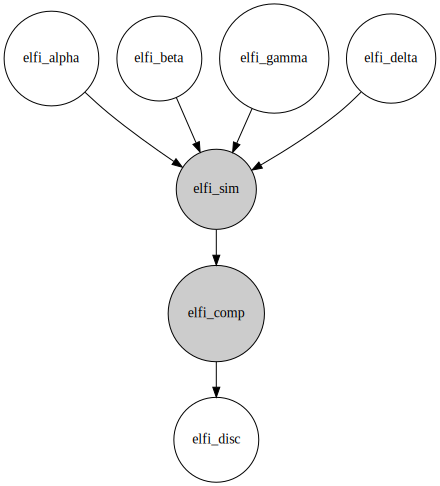

In [12]:
elfi.draw(elfi_disc)

# Define simulation pool

In [13]:
poolid = "arraypool_"+str(seed)
prefix = "sims/pools_sbi"
makedirs(prefix, exist_ok=True)
makedirs(prefix+"/"+poolid, exist_ok=True)

# Run likelihood-free inference

In [14]:
try:
    pool = elfi.ArrayPool.open(poolid, prefix=prefix)
    print("Using existing pool at "+prefix+"/"+poolid)
except IOError:
    print("Using new pool at "+prefix+"/"+poolid)
    pool = elfi.ArrayPool(['elfi_alpha', 'elfi_beta', 'elfi_gamma', 'elfi_delta', 'elfi_sim', 'elfi_comp'], prefix=prefix)

Using existing pool at sims/pools_sbi/arraypool_1


In [15]:
elfi.set_client('multiprocessing')
rej = elfi.Rejection(elfi_disc, pool=pool, batch_size=1, seed=seed)

In [16]:
schedule = [2.]
epsilon = schedule[0]
rej.set_objective(10000, threshold=epsilon)

In [17]:
import time
time0 = time.time()
time1 = time0 + 60*60*12
time2 = time0 + 60
while not rej.finished and time.time() < time1:
    rej.iterate()
    if time.time() > time2:
        pool.save()
        time2=time.time() + 60
        print(str(time.time())+", saving")
print(rej.finished)
pool.save()

1672942475.6128497, saving
1672942535.6213794, saving
1672942595.6228428, saving
1672942655.6239138, saving
1672942715.6331847, saving
1672942775.6340454, saving
1672942835.6348357, saving
1672942895.6380186, saving
1672942955.643037, saving
1672943015.6445901, saving
1672943075.6472447, saving
1672943135.6513705, saving
1672943195.6574495, saving
1672943255.6617842, saving
1672943315.664557, saving
1672943375.6804202, saving
1672943435.6857734, saving
1672943495.6922653, saving
1672943555.6991043, saving
1672943615.7022324, saving
1672943675.7045603, saving
True


In [18]:
pool.save()
res = rej.extract_result()
pool.close()
res

Method: Rejection
Number of samples: 10000
Number of simulations: 754374
Threshold: 2
Sample means: elfi_alpha: 0.5624707145725355, elfi_beta: 0.19952296921152693, elfi_delta: 0.048585316127088586, elfi_gamma: 0.19311320912717803

In [19]:
alpha_pool=np.load(prefix+"/"+poolid+"/elfi_alpha.npy")
beta_pool=np.load(prefix+"/"+poolid+"/elfi_beta.npy")
gamma_pool=np.load(prefix+"/"+poolid+"/elfi_gamma.npy")
delta_pool=np.load(prefix+"/"+poolid+"/elfi_delta.npy")
sim_pool=np.load(prefix+"/"+poolid+"/elfi_sim.npy")
comp_pool=np.load(prefix+"/"+poolid+"/elfi_comp.npy")
pool_size=alpha_pool.shape[0]
print("pool size:",pool_size)
np.savez(prefix+"/"+poolid+'/sbi_pool.npz',alpha_pool=alpha_pool[:10000],beta_pool=beta_pool[:10000],comp_pool=comp_pool[:10000])

pool size: 952140


In [20]:
alpha_samples, alpha_notsamples = {}, {}
beta_samples, beta_notsamples = {}, {}
gamma_samples, gamma_notsamples = {}, {}
delta_samples, delta_notsamples = {}, {}
disc_samples, disc_notsamples = {}, {}
comp_samples, comp_notsamples = {}, {}

disc_pool = cdist(np.atleast_2d(comp_pool), np.atleast_2d(compressed_data), metric='mahalanobis', VI=F_0).flatten()
foo = np.where(disc_pool<epsilon)
notfoo = np.where(disc_pool>=epsilon)
alpha_samples[epsilon], alpha_notsamples[epsilon] = alpha_pool[foo], alpha_pool[notfoo]
beta_samples[epsilon], beta_notsamples[epsilon] = beta_pool[foo], beta_pool[notfoo]
gamma_samples[epsilon], gamma_notsamples[epsilon] = gamma_pool[foo], gamma_pool[notfoo]
delta_samples[epsilon], delta_notsamples[epsilon] = delta_pool[foo], delta_pool[notfoo]
disc_samples[epsilon], disc_notsamples[epsilon] = disc_pool[foo], disc_pool[notfoo]
comp_samples[epsilon], comp_notsamples[epsilon] = comp_pool[foo], comp_pool[notfoo]

In [21]:
nalpha, nbeta, ngamma, ndelta = 100, 100, 100, 100
alphas=np.linspace(alphamin,alphamax,nalpha)
betas=np.linspace(betamin,betamax,nbeta)
gammas=np.linspace(gammamin,gammamax,ngamma)
deltas=np.linspace(deltamin,deltamax,ndelta)

kde_ab = get_kde_values(alpha_samples[epsilon][:10000],beta_samples[epsilon][:10000],alphamin,alphamax,nalpha,betamin,betamax,nbeta)
prior_ab = np.array([[elfi_alpha.distribution.logpdf(alpha, loc=alpha_exp, scale=alpha_exp*inference_prior_deviation) +\
                 elfi_beta.distribution.logpdf(beta, loc=beta_exp, scale=beta_exp*inference_prior_deviation) for alpha in alphas] for beta in betas])
prior_ab -= np.max(prior_ab)

kde_ac = get_kde_values(alpha_samples[epsilon][:10000],gamma_samples[epsilon][:10000],alphamin,alphamax,nalpha,gammamin,gammamax,ngamma)
prior_ac = np.array([[elfi_alpha.distribution.logpdf(alpha, loc=alpha_exp, scale=alpha_exp*inference_prior_deviation) +\
                 elfi_gamma.distribution.logpdf(gamma, loc=gamma_exp, scale=gamma_exp*inference_prior_deviation) for alpha in alphas] for gamma in gammas])
prior_ac -= np.max(prior_ac)

kde_ad = get_kde_values(alpha_samples[epsilon][:10000],delta_samples[epsilon][:10000],alphamin,alphamax,nalpha,deltamin,deltamax,ndelta)
prior_ad = np.array([[elfi_alpha.distribution.logpdf(alpha, loc=alpha_exp, scale=alpha_exp*inference_prior_deviation) +\
                 elfi_delta.distribution.logpdf(delta, loc=delta_exp, scale=delta_exp*inference_prior_deviation) for alpha in alphas] for delta in deltas])
prior_ad -= np.max(prior_ad)

kde_bc = get_kde_values(beta_samples[epsilon][:10000],gamma_samples[epsilon][:10000],betamin,betamax,nbeta,gammamin,gammamax,ngamma)
prior_bc = np.array([[elfi_beta.distribution.logpdf(beta, loc=beta_exp, scale=beta_exp*inference_prior_deviation) +\
                 elfi_gamma.distribution.logpdf(gamma, loc=gamma_exp, scale=gamma_exp*inference_prior_deviation) for beta in betas] for gamma in gammas])
prior_bc -= np.max(prior_bc)

kde_bd = get_kde_values(beta_samples[epsilon][:10000],delta_samples[epsilon][:10000],betamin,betamax,nbeta,deltamin,deltamax,ndelta)
prior_bd = np.array([[elfi_beta.distribution.logpdf(beta, loc=beta_exp, scale=beta_exp*inference_prior_deviation) +\
                 elfi_delta.distribution.logpdf(delta, loc=delta_exp, scale=delta_exp*inference_prior_deviation) for beta in betas] for delta in deltas])
prior_bd -= np.max(prior_bd)

kde_cd = get_kde_values(gamma_samples[epsilon][:10000],delta_samples[epsilon][:10000],gammamin,gammamax,ngamma,deltamin,deltamax,ndelta)
prior_cd = np.array([[elfi_gamma.distribution.logpdf(gamma, loc=gamma_exp, scale=gamma_exp*inference_prior_deviation) +\
                 elfi_delta.distribution.logpdf(delta, loc=delta_exp, scale=delta_exp*inference_prior_deviation) for gamma in gammas] for delta in deltas])
prior_cd -= np.max(prior_cd)

 /tmp/ipykernel_983194/2786492658.py:9: RuntimeWarning:divide by zero encountered in log


Text(0.5, 0, 'discrepancy')

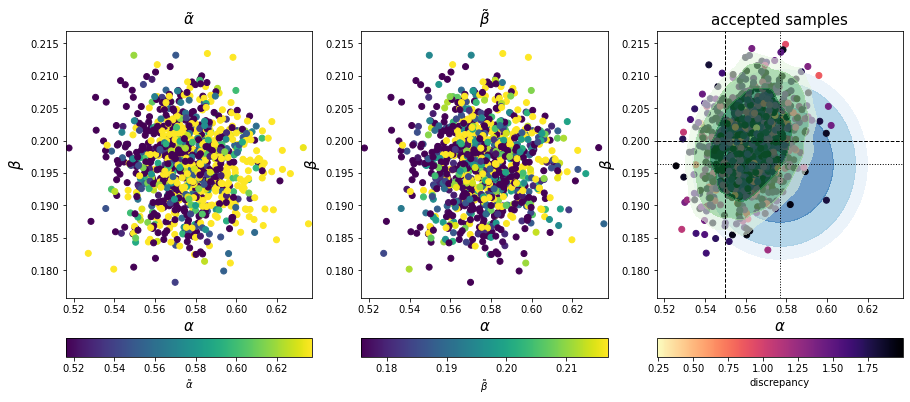

In [22]:
N=1000
fig=plt.figure(figsize=(15,6))

ax0=fig.add_subplot(1,3,1)
ax0.set_xlabel("$\\alpha$",fontsize=15)
ax0.set_ylabel("$\\beta$",fontsize=15)
ax0.set_title("$\\tilde{\\alpha}}$",fontsize=15)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
im0 = ax0.scatter(alpha_pool[:N], beta_pool[:N], c=comp_pool[:N].T[0], vmin=alphamin, vmax=alphamax)
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad="15%")
cb0 = colorbar(im0, cax=cax0, orientation="horizontal")
cb0.ax.set_xlabel("$\\tilde{\\alpha}$")

ax1=fig.add_subplot(1,3,2)
ax1.set_xlabel("$\\alpha$",fontsize=15)
ax1.set_ylabel("$\\beta$",fontsize=15)
ax1.set_title("$\\tilde{\\beta}$",fontsize=15)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
im1 = ax1.scatter(alpha_pool[:N], beta_pool[:N], c=comp_pool[:N].T[1], vmin=betamin, vmax=betamax)
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="15%")
cb1 = colorbar(im1, cax=cax1, orientation="horizontal")
cb1.ax.set_xlabel("$\\tilde{\\beta}$")

ax2=fig.add_subplot(1,3,3)
ax2.set_xlabel("$\\alpha$",fontsize=15)
ax2.set_ylabel("$\\beta$",fontsize=15)
ax2.set_title("accepted samples",fontsize=15)
ax2.set_xlim([alphamin,alphamax])
ax2.set_ylim([betamin,betamax])
ax2.axvline(alpha_gt,lw=1,ls="--",color="k")
ax2.axhline(beta_gt,lw=1,ls="--",color="k")
ax2.axvline(alpha_exp,lw=1,ls=":",color="k")
ax2.axhline(beta_exp,lw=1,ls=":",color="k")
im2 = ax2.scatter(alpha_samples[epsilon][:N], beta_samples[epsilon][:N], c=disc_samples[epsilon][:N], cmap='magma_r', zorder=1)
ax2.contourf(alphas,betas,prior_ab,confLevels_grid,cmap="Blues",alpha=0.6,zorder=0)
ax2.contourf(alphas,betas,kde_ab,confLevels_grid,cmap="Greens",alpha=0.6,zorder=2)
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("bottom", size="7%", pad="15%")
cb2 = colorbar(im2, cax=cax2, orientation="horizontal")
cb2.ax.set_xlabel("discrepancy")

In [23]:
pdf_alpha = get_marginal(alpha_samples[epsilon], nBins=40)
pdf_beta = get_marginal(beta_samples[epsilon], nBins=40)
pdf_gamma = get_marginal(gamma_samples[epsilon], nBins=40)
pdf_delta = get_marginal(delta_samples[epsilon], nBins=40)

In [24]:
prior_a = np.array([elfi_alpha.distribution.pdf(alpha, loc=alpha_exp, scale=alpha_exp*inference_prior_deviation) for alpha in alphas])
prior_a /= prior_a.max()
prior_b = np.array([elfi_beta.distribution.pdf(beta, loc=beta_exp, scale=beta_exp*inference_prior_deviation) for beta in betas])
prior_b /= prior_b.max()
prior_c = np.array([elfi_gamma.distribution.pdf(gamma, loc=gamma_exp, scale=gamma_exp*inference_prior_deviation) for gamma in gammas])
prior_c /= prior_c.max()
prior_d = np.array([elfi_delta.distribution.pdf(delta, loc=delta_exp, scale=delta_exp*inference_prior_deviation) for delta in deltas])
prior_d /= prior_d.max()

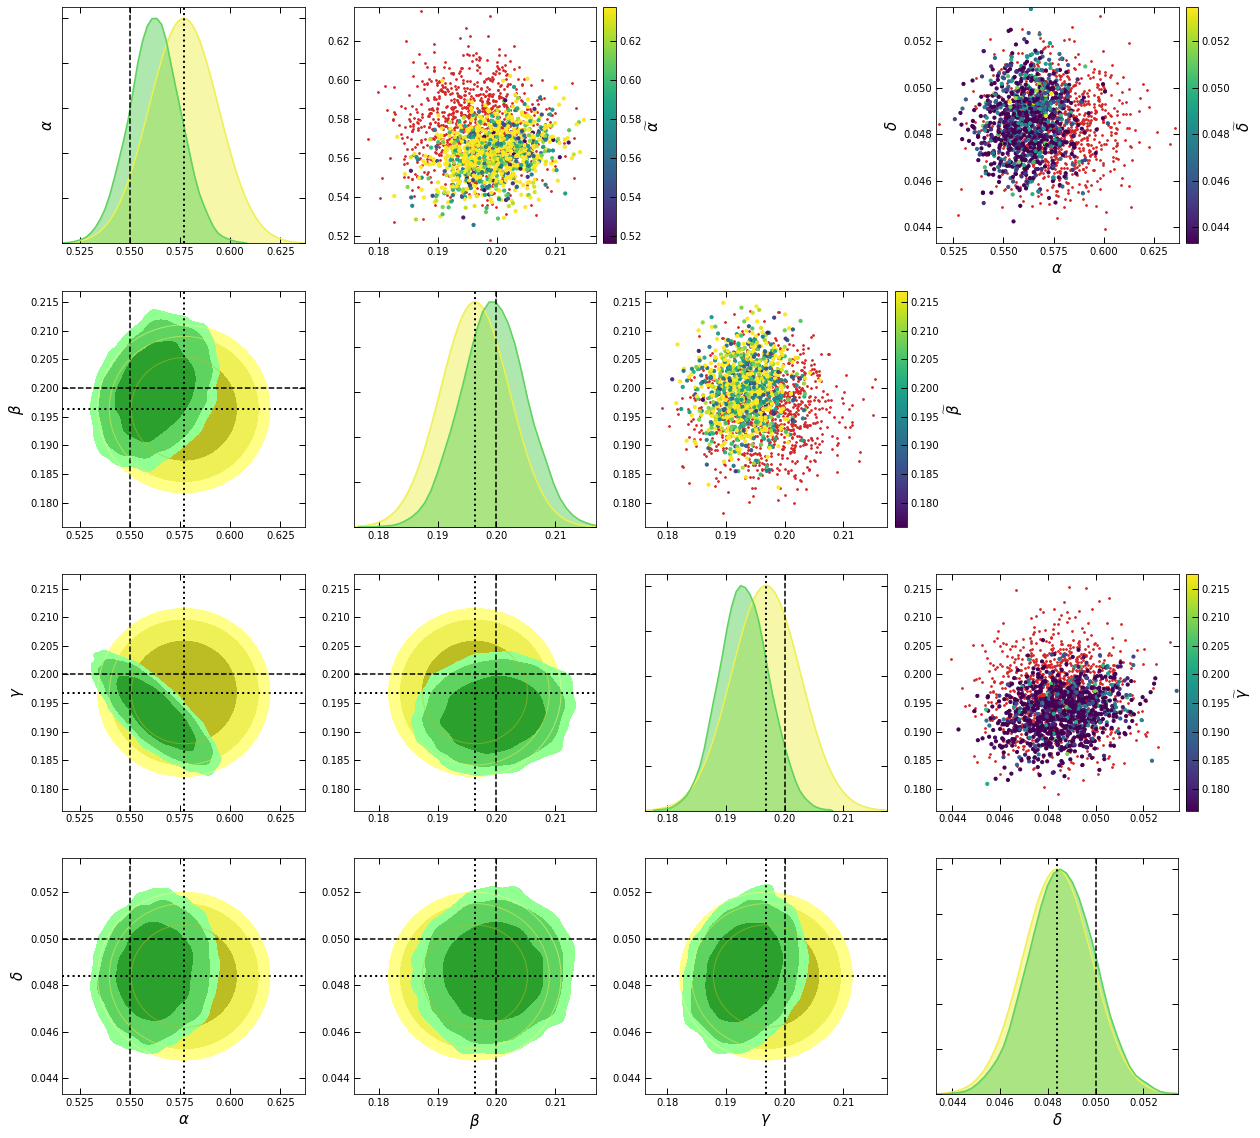

In [25]:
N=1000
fig = plt.figure(figsize=(20,20))

gs0 = gridspec.GridSpec(4,4, width_ratios=[1.,1.,1.,1.], height_ratios=[1.,1.,1.,1.], wspace=0.2, hspace=0.2)

ax0a = plt.subplot(gs0[0,0])
ax0b = plt.subplot(gs0[1,0])
ax0c = plt.subplot(gs0[2,0])
ax0d = plt.subplot(gs0[3,0])
ax1a = plt.subplot(gs0[0,1])
ax1b = plt.subplot(gs0[1,1])
ax1c = plt.subplot(gs0[2,1])
ax1d = plt.subplot(gs0[3,1])
# ax2a = plt.subplot(gs0[0,2])
ax2b = plt.subplot(gs0[1,2])
ax2c = plt.subplot(gs0[2,2])
ax2d = plt.subplot(gs0[3,2])
ax3a = plt.subplot(gs0[0,3])
# ax3b = plt.subplot(gs0[1,3])
ax3c = plt.subplot(gs0[2,3])
ax3d = plt.subplot(gs0[3,3])

pos1a = ax1a.get_position()
pos1a_bounds = np.array(pos1a.bounds)
pos1a_bounds[2]+=0.0135
ax1a.set_position(Bbox.from_bounds(*pos1a_bounds))

pos2b = ax2b.get_position()
pos2b_bounds = np.array(pos2b.bounds)
pos2b_bounds[2]+=0.0135
ax2b.set_position(Bbox.from_bounds(*pos2b_bounds))

pos3a = ax3a.get_position()
pos3a_bounds = np.array(pos3a.bounds)
pos3a_bounds[2]+=0.0135
ax3a.set_position(Bbox.from_bounds(*pos3a_bounds))

pos3c = ax3c.get_position()
pos3c_bounds = np.array(pos3c.bounds)
pos3c_bounds[2]+=0.0135
ax3c.set_position(Bbox.from_bounds(*pos3c_bounds))

for ax in {ax0a,ax0b,ax0c,ax0d,ax1a,ax1b,ax1c,ax1d,ax2b,ax2c,ax2d,ax3a,ax3c,ax3d}:
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_tick_params(which='both', direction='in', width=1.0)
    ax.xaxis.set_tick_params(which='major', length=6)
    ax.xaxis.set_tick_params(which='minor', length=4)
    ax.yaxis.set_tick_params(which='both', direction='in', width=1.0)
    ax.yaxis.set_tick_params(which='major', length=6)
for ax in {ax1a,ax1b,ax1c,ax1d,ax2b,ax2c,ax2d}:
    ax.set_xticks([0.18,0.19,0.20,0.21])
for ax in {ax0a,ax0b,ax0c,ax0d,ax3a}:
    ax.set_xticks([0.525,0.550,0.575,0.600,0.625])
for ax in {ax3c,ax3d}:
    ax.set_xticks([0.044,0.046,0.048,0.050,0.052])

# Score compression
# ax1a.set_xlabel("$\\beta$",fontsize=15)
# ax1a.set_ylabel("$\\alpha$",fontsize=15)
# ax1a.set_title("$\\tilde{\\alpha}}$",fontsize=15)
ax1a.set_xlim([betamin,betamax])
ax1a.set_ylim([alphamin,alphamax])
im1a0 = ax1a.scatter(beta_pool[:N], alpha_pool[:N], color='C3', s=3.)
im1a1 = ax1a.scatter(beta_samples[epsilon][:N], alpha_samples[epsilon][:N], c=comp_samples[epsilon][:N,0], cmap='viridis', s=10., vmin=alphamin, vmax=alphamax)
divider = make_axes_locatable(ax1a)
ax1a_cb = divider.new_horizontal(size="5%", pad=0.10)
fig.add_axes(ax1a_cb)
cbar1a = fig.colorbar(im1a1, cax=ax1a_cb)
cbar1a.ax.tick_params(axis='y', direction='in', width=1.0, length=6)
cbar1a.ax.set_ylabel("$\\widetilde{\\alpha}$",fontsize=15)

ax3a.set_xlabel("$\\alpha$",fontsize=15)
ax3a.set_ylabel("$\\delta$",fontsize=15)
# ax3a.set_title("$\\tilde{\\delta}}$",fontsize=15)
ax3a.set_xlim([alphamin,alphamax])
ax3a.set_ylim([deltamin,deltamax])
im3a0 = ax3a.scatter(alpha_pool[:N], delta_pool[:N], color='C3', s=3.)
im3a1 = ax3a.scatter(alpha_samples[epsilon][:N], delta_samples[epsilon][:N], c=comp_samples[epsilon][:N,3], cmap='viridis', s=10., vmin=deltamin, vmax=deltamax)
divider = make_axes_locatable(ax3a)
ax3a_cb = divider.new_horizontal(size="5%", pad=0.10)
fig.add_axes(ax3a_cb)
cbar3a = fig.colorbar(im3a1, cax=ax3a_cb)
cbar3a.ax.tick_params(axis='y', direction='in', width=1.0, length=6)
cbar3a.ax.set_ylabel("$\\widetilde{\\delta}$",fontsize=15)

# ax2b.set_xlabel("$\\gamma$",fontsize=15)
# ax2b.set_ylabel("$\\beta$",fontsize=15)
# ax2b.set_title("$\\tilde{\\beta}}$",fontsize=15)
ax2b.set_xlim([gammamin,gammamax])
ax2b.set_ylim([betamin,betamax])
im2b0 = ax2b.scatter(gamma_pool[:N], beta_pool[:N], color='C3', s=3.)
im2b1 = ax2b.scatter(gamma_samples[epsilon][:N], beta_samples[epsilon][:N], c=comp_samples[epsilon][:N,1], cmap='viridis', s=10., vmin=betamin, vmax=betamax)
divider = make_axes_locatable(ax2b)
ax2b_cb = divider.new_horizontal(size="5%", pad=0.10)
fig.add_axes(ax2b_cb)
cbar2b = fig.colorbar(im2b1, cax=ax2b_cb)
cbar2b.ax.tick_params(axis='y', direction='in', width=1.0, length=6)
cbar2b.ax.set_ylabel("$\\widetilde{\\beta}$",fontsize=15)

# ax3c.set_xlabel("$\\delta$",fontsize=15)
# ax3c.set_ylabel("$\\gamma$",fontsize=15)
# ax3c.set_title("$\\tilde{\\gamma}}$",fontsize=15)
ax3c.set_xlim([deltamin,deltamax])
ax3c.set_ylim([gammamin,gammamax])
im3c0 = ax3c.scatter(delta_pool[:N], gamma_pool[:N], color='C3', s=3.)
im3c1 = ax3c.scatter(delta_samples[epsilon][:N], gamma_samples[epsilon][:N], c=comp_samples[epsilon][:N,2], cmap='viridis', s=10., vmin=gammamin, vmax=gammamax)
divider = make_axes_locatable(ax3c)
ax3c_cb = divider.new_horizontal(size="5%", pad=0.10)
fig.add_axes(ax3c_cb)
cbar3c = fig.colorbar(im3c1, cax=ax3c_cb)
cbar3c.ax.tick_params(axis='y', direction='in', width=1.0, length=6)
cbar3c.ax.set_ylabel("$\\widetilde{\\gamma}$",fontsize=15)

# 2D contours
# ax0b.set_xlabel("$\\alpha$",fontsize=15)
ax0b.set_ylabel("$\\beta$",fontsize=15)
ax0b.set_xlim([alphamin,alphamax])
ax0b.set_ylim([betamin,betamax])
ax0b.axvline(alpha_gt,lw=1.5,ls="--",color="k")
ax0b.axhline(beta_gt,lw=1.5,ls="--",color="k")
ax0b.axvline(alpha_exp,lw=2,ls=":",color="k")
ax0b.axhline(beta_exp,lw=2,ls=":",color="k")
# im0b = ax0b.scatter(alpha_samples[epsilon][:N], beta_samples[epsilon][:N], c=disc_samples[epsilon][:N], cmap='magma_r', s=10., zorder=1)
ax0b.contourf(alphas,betas,prior_ab,confLevels_grid,colors=np.flip(colors[8]),zorder=0)
ax0b.contourf(alphas,betas,kde_ab,confLevels_grid,colors=np.flip(colors[2]),zorder=2)
ax0b.contour(alphas,betas,prior_ab,confLevels_grid,colors=np.flip(colors[8]), linewidths=1., alpha=0.5, zorder=3)

# ax0c.set_xlabel("$\\alpha$",fontsize=15)
ax0c.set_ylabel("$\\gamma$",fontsize=15)
ax0c.set_xlim([alphamin,alphamax])
ax0c.set_ylim([gammamin,gammamax])
ax0c.axvline(alpha_gt,lw=1.5,ls="--",color="k")
ax0c.axhline(gamma_gt,lw=1.5,ls="--",color="k")
ax0c.axvline(alpha_exp,lw=2,ls=":",color="k")
ax0c.axhline(gamma_exp,lw=2,ls=":",color="k")
# im0c = ax0c.scatter(alpha_samples[epsilon][:N], gamma_samples[epsilon][:N], c=disc_samples[epsilon][:N], cmap='magma_r', s=10., zorder=1)
ax0c.contourf(alphas,gammas,prior_ac,confLevels_grid,colors=np.flip(colors[8]),zorder=0)
ax0c.contourf(alphas,gammas,kde_ac,confLevels_grid,colors=np.flip(colors[2]),zorder=2)
ax0c.contour(alphas,gammas,prior_ac,confLevels_grid,colors=np.flip(colors[8]), linewidths=1., alpha=0.5, zorder=3)

# ax1c.set_xlabel("$\\beta$",fontsize=15)
# ax1c.set_ylabel("$\\gamma$",fontsize=15)
ax1c.set_xlim([betamin,betamax])
ax1c.set_ylim([gammamin,gammamax])
ax1c.axvline(beta_gt,lw=1.5,ls="--",color="k")
ax1c.axhline(gamma_gt,lw=1.5,ls="--",color="k")
ax1c.axvline(beta_exp,lw=2,ls=":",color="k")
ax1c.axhline(gamma_exp,lw=2,ls=":",color="k")
# im1c = ax1c.scatter(beta_samples[epsilon][:N], gamma_samples[epsilon][:N], c=disc_samples[epsilon][:N], cmap='magma_r', s=10., zorder=1)
ax1c.contourf(betas,gammas,prior_bc,confLevels_grid,colors=np.flip(colors[8]),zorder=0)
ax1c.contourf(betas,gammas,kde_bc,confLevels_grid,colors=np.flip(colors[2]),zorder=2)
ax1c.contour(betas,gammas,prior_bc,confLevels_grid,colors=np.flip(colors[8]), linewidths=1., alpha=0.5, zorder=3)

ax0d.set_xlabel("$\\alpha$",fontsize=15)
ax0d.set_ylabel("$\\delta$",fontsize=15)
ax0d.set_xlim([alphamin,alphamax])
ax0d.set_ylim([deltamin,deltamax])
ax0d.axvline(alpha_gt,lw=1.5,ls="--",color="k")
ax0d.axhline(delta_gt,lw=1.5,ls="--",color="k")
ax0d.axvline(alpha_exp,lw=2,ls=":",color="k")
ax0d.axhline(delta_exp,lw=2,ls=":",color="k")
# im0d = ax0d.scatter(alpha_samples[epsilon][:N], delta_samples[epsilon][:N], c=disc_samples[epsilon][:N], cmap='magma_r', s=10., zorder=1)
ax0d.contourf(alphas,deltas,prior_ad,confLevels_grid,colors=np.flip(colors[8]),zorder=0)
ax0d.contourf(alphas,deltas,kde_ad,confLevels_grid,colors=np.flip(colors[2]),zorder=2)
ax0d.contour(alphas,deltas,prior_ad,confLevels_grid,colors=np.flip(colors[8]), linewidths=1., alpha=0.5, zorder=3)

ax1d.set_xlabel("$\\beta$",fontsize=15)
# ax1d.set_ylabel("$\\delta$",fontsize=15)
ax1d.set_xlim([betamin,betamax])
ax1d.set_ylim([deltamin,deltamax])
ax1d.axvline(beta_gt,lw=1.5,ls="--",color="k")
ax1d.axhline(delta_gt,lw=1.5,ls="--",color="k")
ax1d.axvline(beta_exp,lw=2,ls=":",color="k")
ax1d.axhline(delta_exp,lw=2,ls=":",color="k")
# im1d = ax1d.scatter(beta_samples[epsilon][:N], delta_samples[epsilon][:N], c=disc_samples[epsilon:][:N], cmap='magma_r', s=10., zorder=1)
ax1d.contourf(betas,deltas,prior_bd,confLevels_grid,colors=np.flip(colors[8]),zorder=0)
ax1d.contourf(betas,deltas,kde_bd,confLevels_grid,colors=np.flip(colors[2]),zorder=2)
ax1d.contour(betas,deltas,prior_bd,confLevels_grid,colors=np.flip(colors[8]), linewidths=1., alpha=0.5, zorder=3)

ax2d.set_xlabel("$\\gamma$",fontsize=15)
# ax2d.set_ylabel("$\\delta$",fontsize=15)
ax2d.set_xlim([gammamin,gammamax])
ax2d.set_ylim([deltamin,deltamax])
ax2d.axvline(gamma_gt,lw=1.5,ls="--",color="k")
ax2d.axhline(delta_gt,lw=1.5,ls="--",color="k")
ax2d.axvline(gamma_exp,lw=2,ls=":",color="k")
ax2d.axhline(delta_exp,lw=2,ls=":",color="k")
# im2d = ax2d.scatter(gamma_samples[epsilon][:N], delta_samples[epsilon][:N], c=disc_samples[epsilon][:N], cmap='magma_r', s=10., zorder=1)
ax2d.contourf(gammas,deltas,prior_cd,confLevels_grid,colors=np.flip(colors[8]),zorder=0)
ax2d.contourf(gammas,deltas,kde_cd,confLevels_grid,colors=np.flip(colors[2]),zorder=2)
ax2d.contour(gammas,deltas,prior_cd,confLevels_grid,colors=np.flip(colors[8]), linewidths=1., alpha=0.5, zorder=3)

ax3d.set_xlabel("$\\delta$",fontsize=15)

# 1D marginals
ax0a.set_ylabel("$\\alpha$",fontsize=15)
ax0a.set_yticklabels("")
ax0a.fill_between(alphas,prior_a, 0, color=colors[8][1], alpha=0.5)
ax0a.fill_between(pdf_alpha[0],pdf_alpha[1], 0, color=colors[2][1], alpha=0.5)
ax0a.plot(alphas,prior_a, color=colors[8][1])
ax0a.plot(pdf_alpha[0],pdf_alpha[1], color=colors[2][1])
ax0a.set_xlim([alphamin,alphamax])
ax0a.set_ylim([0.,pdf_alpha[1].max()*1.05])
ax0a.axvline(alpha_gt,lw=1.5,ls='--',color='black')
ax0a.axvline(alpha_exp,lw=2,ls=':',color='black')

ax1b.set_yticklabels("")
ax1b.fill_between(betas,prior_b, 0, color=colors[8][1], alpha=0.5)
ax1b.fill_between(pdf_beta[0],pdf_beta[1], 0, color=colors[2][1], alpha=0.5)
ax1b.plot(betas,prior_b, color=colors[8][1])
ax1b.plot(pdf_beta[0],pdf_beta[1], color=colors[2][1])
ax1b.set_xlim([betamin,betamax])
ax1b.set_ylim([0.,pdf_beta[1].max()*1.05])
ax1b.axvline(beta_gt,lw=1.5,ls='--',color='black')
ax1b.axvline(beta_exp,lw=2,ls=':',color='black')

ax2c.set_yticklabels("")
ax2c.fill_between(gammas,prior_c, 0, color=colors[8][1], alpha=0.5)
ax2c.fill_between(pdf_gamma[0],pdf_gamma[1], 0, color=colors[2][1], alpha=0.5)
ax2c.plot(gammas,prior_c, color=colors[8][1])
ax2c.plot(pdf_gamma[0],pdf_gamma[1], color=colors[2][1])
ax2c.set_xlim([gammamin,gammamax])
ax2c.set_ylim([0.,pdf_gamma[1].max()*1.05])
ax2c.axvline(gamma_gt,lw=1.5,ls='--',color='black')
ax2c.axvline(gamma_exp,lw=2,ls=':',color='black')

ax3d.set_yticklabels("")
ax3d.fill_between(deltas,prior_d, 0, color=colors[8][1], alpha=0.5)
ax3d.fill_between(pdf_delta[0],pdf_delta[1], 0, color=colors[2][1], alpha=0.5)
ax3d.plot(deltas,prior_d, color=colors[8][1])
ax3d.plot(pdf_delta[0],pdf_delta[1], color=colors[2][1])
ax3d.set_xlim([deltamin,deltamax])
ax3d.set_ylim([0.,pdf_delta[1].max()*1.05])
ax3d.axvline(delta_gt,lw=1.5,ls='--',color='black')
ax3d.axvline(delta_exp,lw=2,ls=':',color='black')

plt.show()

In [26]:
np.savez("plots/abc",epsilon=epsilon,compressed_data=compressed_data,
         alpha_samples=np.array(alpha_samples,dtype=object),beta_samples=np.array(beta_samples,dtype=object),
         gamma_samples=gamma_samples,delta_samples=delta_samples,comp_samples=comp_samples,
         alpha_pool=alpha_pool,beta_pool=beta_pool,gamma_pool=gamma_pool,
         delta_pool=delta_pool,pdf_alpha=pdf_alpha,pdf_beta=pdf_beta,pdf_gamma=pdf_gamma,
         pdf_delta=pdf_delta,prior_a=prior_a,prior_b=prior_b,prior_c=prior_c,prior_d=prior_d,
         kde_ab=kde_ab,kde_ac=kde_ac,kde_ad=kde_ad,kde_bc=kde_bc,kde_bd=kde_bd,kde_cd=kde_cd,
         prior_ab=prior_ab,prior_ac=prior_ac,prior_ad=prior_ad,prior_bc=prior_bc,prior_bd=prior_bd,
         prior_cd=prior_cd,
         alphamin=alphamin,alphamax=alphamax,alphas=alphas,
         betamin=betamin,betamax=betamax,betas=betas,
         gammamin=gammamin,gammamax=gammamax,gammas=gammas,
         deltamin=deltamin,deltamax=deltamax,deltas=deltas,
         alpha_gt=alpha_gt,beta_gt=beta_gt,gamma_gt=gamma_gt,delta_gt=delta_gt,
         alpha_exp=alpha_exp,beta_exp=beta_exp,gamma_exp=gamma_exp,delta_exp=delta_exp)